# Imports

In [1]:
import sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.metrics import pairwise_distances
from PIL import Image
from sklearn.metrics import pairwise_distances
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

from DataSetFactory import DataSetFactory
from AMAP import AMAP

In [2]:
RANDOM_STATE = 42
# SAMPLE_SIZE=0.1

In [15]:
# ds = DataSetFactory.get_dataset('shuttle', sample=SAMPLE_SIZE, random_state=RANDOM_STATE)
ds = DataSetFactory.get_dataset('shuttle', random_state=RANDOM_STATE)

Normalizing features using min max scaler


In [16]:
X = ds.df[ds.feature_cols].values
y = ds.df[ds.label_col].values

In [17]:
X.shape

(43500, 9)

# Birch Threshold

In [8]:
def get_num_clusters_birch(ds, threshold):
    num_clusters = 0
    for label in ds.df[ds.label_col].unique():
        label_data = ds.df[ds.df[ds.label_col]==label][ds.feature_cols].values
        birch = Birch(threshold=threshold, branching_factor=2, n_clusters=None)
        birch.fit(label_data)
        num_clusters += birch.subcluster_centers_.shape[0]
    return num_clusters

def birch_threshold_plot(X, ds):
    dist_mat = pairwise_distances(X)
    print(dist_mat.shape)
    threshold_candidates = np.unique(dist_mat)
    print(threshold_candidates.shape)
    # for the sake of the experiment let's evaluate all of them
    thresholds_df = pd.DataFrame(threshold_candidates, columns=['threshold'])
    thresholds_df['num_clusters'] = np.nan
    thresholds_df['num_points'] = ds.df.shape[0]
    thresholds_df.hist(['threshold'])
    plt.show()
    # Filter only thresholds smaller than 1.5
    thresholds_df_sample = thresholds_df[thresholds_df['threshold']<=0.2]
    thresholds_df_sample = thresholds_df_sample.sample(n=200, random_state=RANDOM_STATE)
#     thresholds_df_sample = thresholds_df.sample(n=200)
    
    thresholds_df_sample['num_clusters'] = thresholds_df_sample['threshold'].transform(lambda t: get_num_clusters_birch(ds, t))
    thresholds_df_sample['compression'] = thresholds_df_sample['num_points'] / thresholds_df_sample['num_clusters']
    
    sns.lineplot(x='threshold', y='compression', data=thresholds_df_sample)
    sns.lineplot(x='threshold', y='num_clusters', data=thresholds_df_sample)

(4350, 4350)
(9109689,)


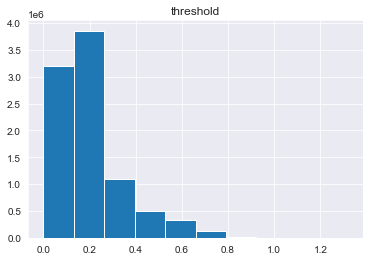

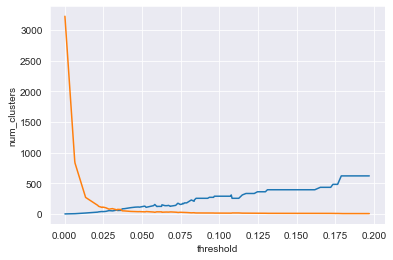

In [9]:
birch_threshold_plot(X, ds)

# Unsupervised UMAP

In [22]:
umap_amap = AMAP(dim_reduction_algo='umap',
            reduce_all_points=True,
            n_iter=1, 
            batch_size=0,
            learning_rate=0.1,
            do_animation=False,
            dataset='Shuttle',
            class_to_label=ds.class_to_label,
            show_fig=True,
            save_fig=True,
            random_state=RANDOM_STATE,
            show_anchors=False,
            supervised=False,
            show_points=True,
            show_inner_blobs=False,
            show_polygons=False,
            show_label_level_plots=False,
            show_anchor_level_plot=False,
            annotate_images=False,
            birch_threshold=0.015,
            umap_n_neighbors=300)
print(umap_amap)

AMAP
addr:@357dc8
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=0.015
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=300
umap_min_dist=1
reduce_all_points=True
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function AMAP.l_inf_loss at 0x00000231C7B340D8>
loss='Linf'
only_inter_relations=False
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={1: 'Class_2', 3: 'Class_4', 0: 'Class_1', 4: 'Class_5', 2: 'Class_3', 6: 'Class_7', 5: 'Class_6'}
random_state=42
n_jobs=None
dataset='Shuttle'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=None
douglas_peucker_tolerance=0.6
smooth_iter=13
skip_polygons_with_area=0.01
show_relations=False
mask_relation_in_same_label=False
save_fig_every=1
show_poin

In [24]:
ds.df[ds.label_col].value_counts().sort_index()

0    34108
1       37
2      132
3     6748
4     2458
5        6
6       11
Name: 9, dtype: int64

finding intra class anchors using birch
UnSupervised Dim Reduction
Dim Reduction all points


C:\Users\omalkai\AppData\Local\Continuum\anaconda3_new\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\..\AppData\Local\Continuum\anaconda3_new\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^


C:\Users\omalkai\AppData\Local\Continuum\anaconda3_new\lib\site-packages\umap\spectral.py:229: UserWarning:

Embedding a total of 84 separate connected components using meta-embedding (experimental)



Starting iteration 1 loss = 1.0


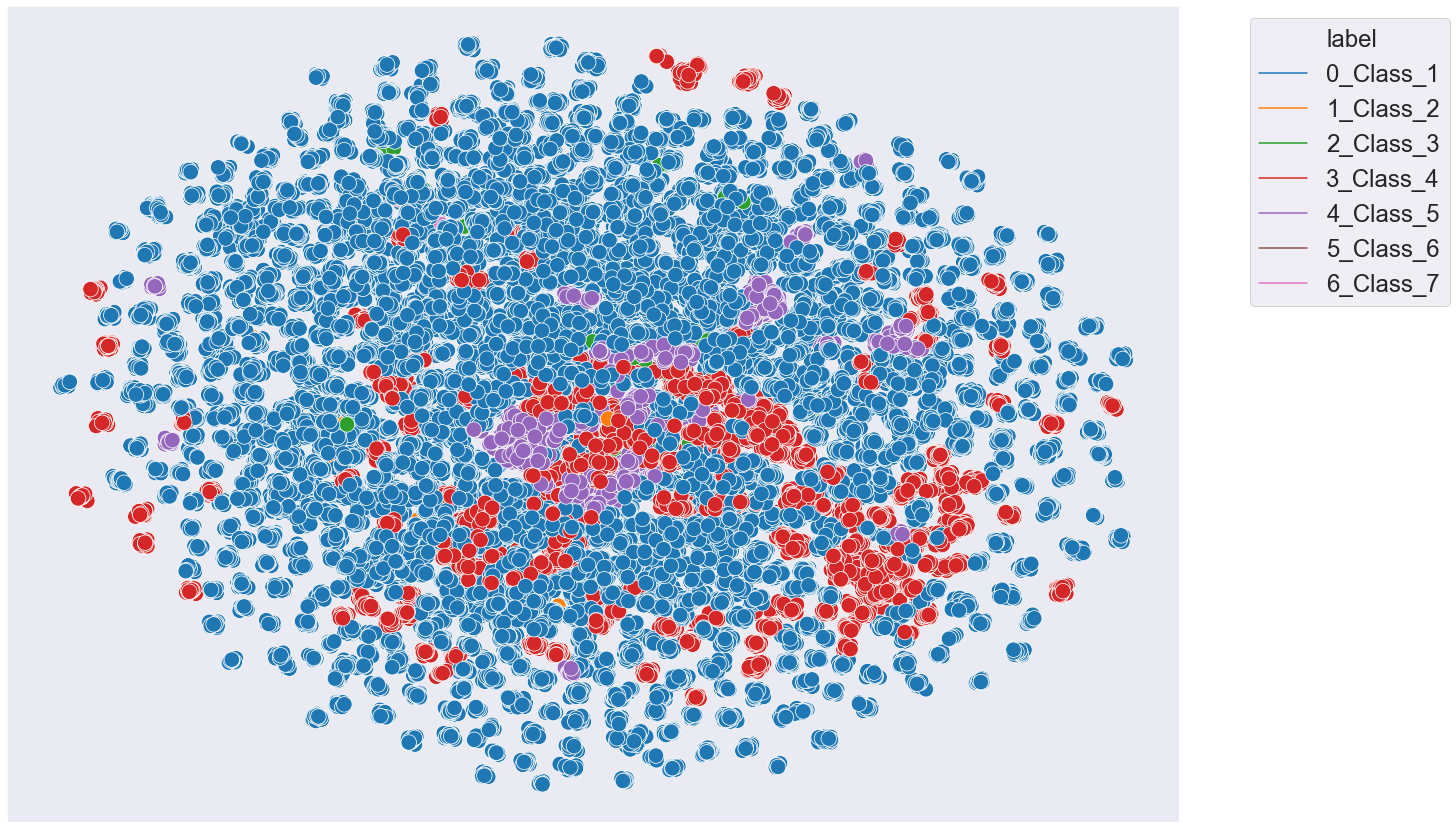

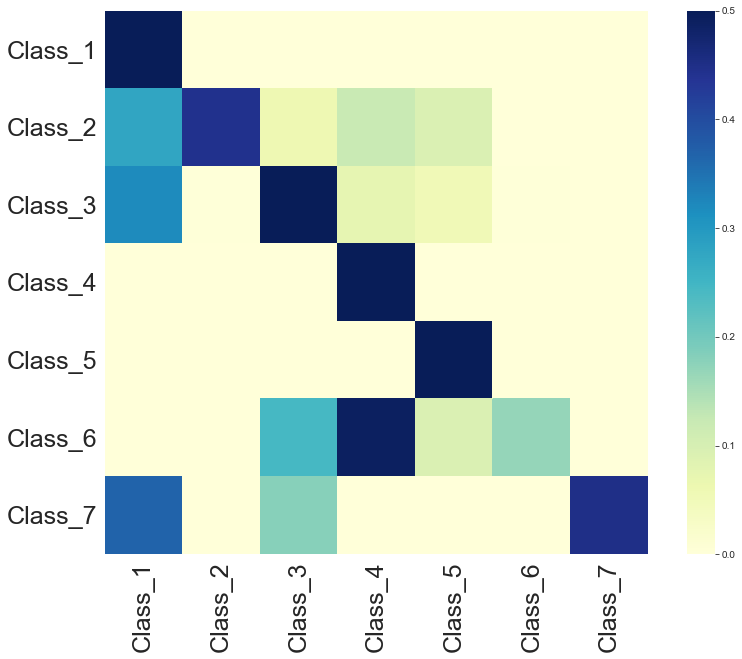

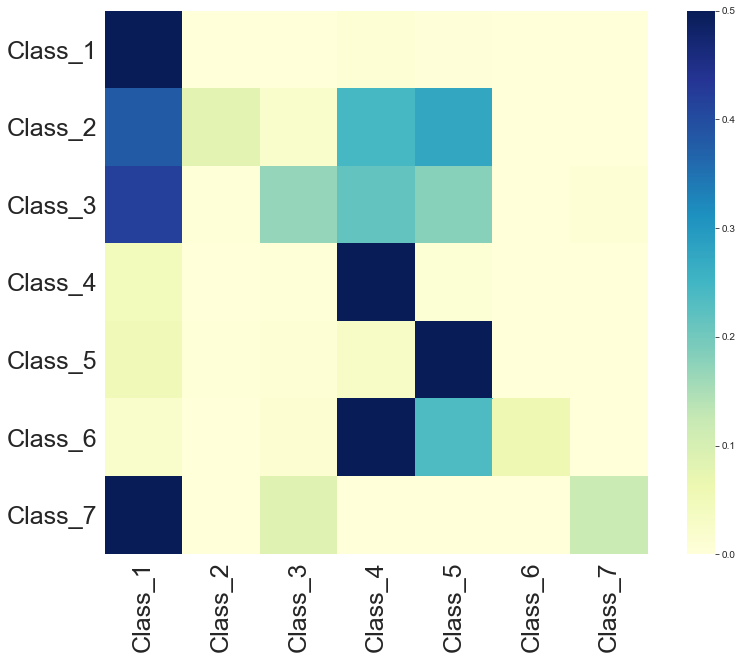

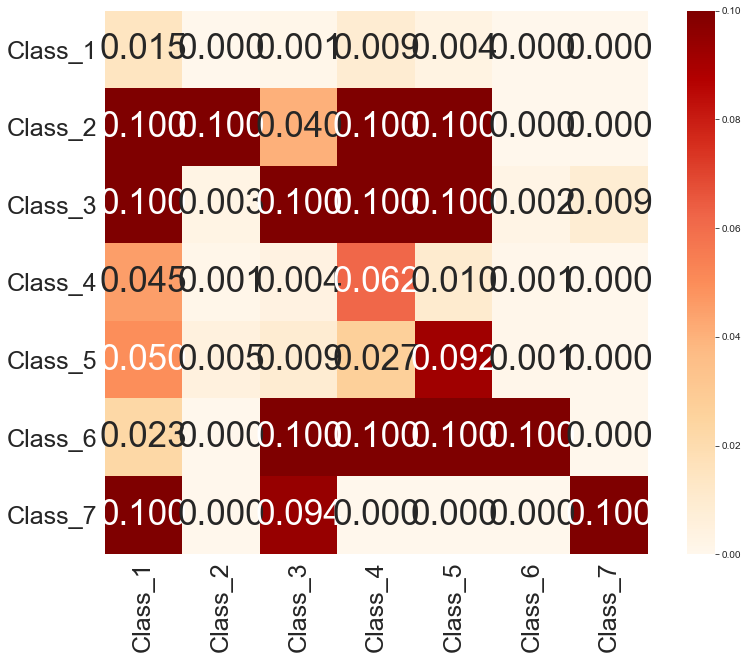

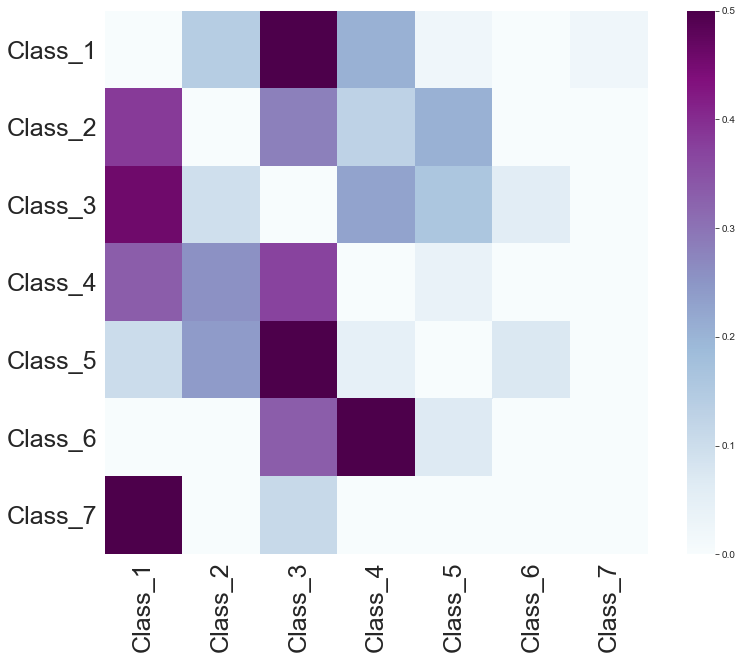

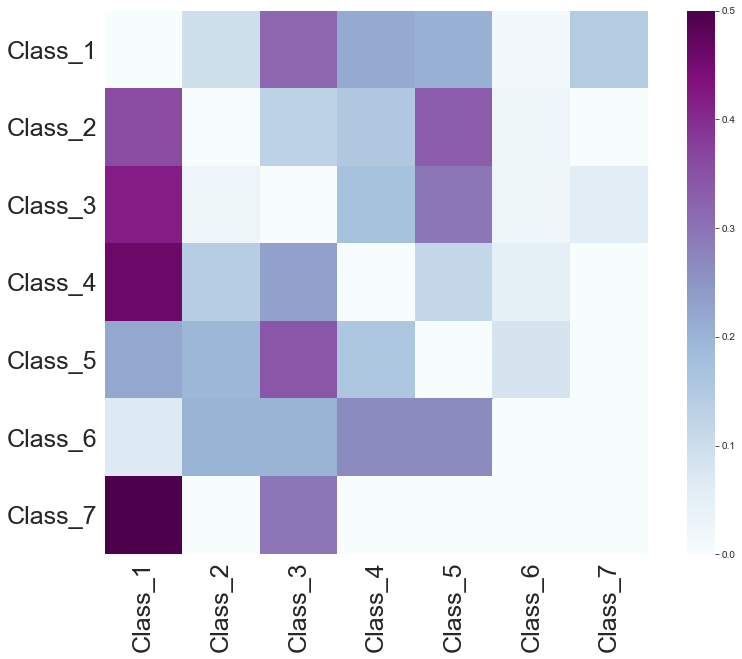

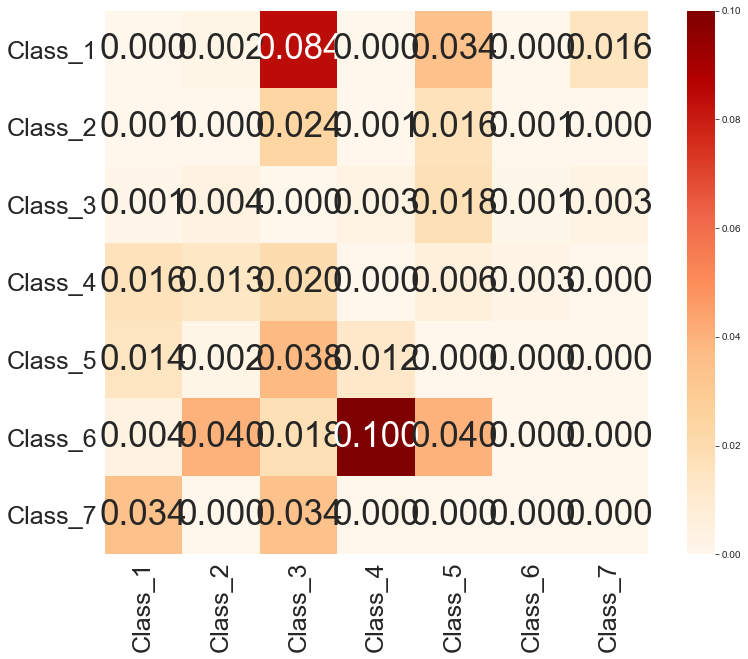

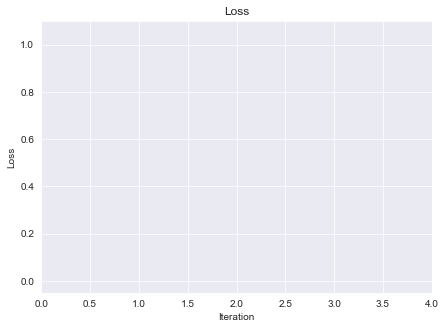

In [23]:
low_dim_umap = umap_amap.fit_transform(X, y)

# AMAP

In [15]:
blobs_amap = AMAP(reduce_all_points=False,
                  n_iter=1, 
                  batch_size=0,
                  learning_rate=0.1,
                  dataset='Wine',
                  class_to_label=ds.class_to_label,
                  show_fig=True,
                  save_fig=True,
                  random_state=RANDOM_STATE,
                  show_anchors=False,
                  supervised=False,
                  show_points=False,
                  show_inner_blobs=False,
                  show_polygons=True,
                  show_label_level_plots=False,
                  show_anchor_level_plot=False,
                  save_fig_every=25,
                  annotate_images=False,
                  birch_threshold=0.2,
                  alpha=0,
                  douglas_peucker_tolerance=0.5,
                  smooth_iter=3,
                  magnitude_step=False)
print(blobs_amap)

AMAP
addr:@48d1c8
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=0.2
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
reduce_all_points=False
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function AMAP.l_inf_loss at 0x00000204A416AC18>
loss='Linf'
only_inter_relations=False
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={2: 'Quality_5', 3: 'Quality_6', 4: 'Quality_7', 1: 'Quality_4', 5: 'Quality_8', 0: 'Quality_3', 6: 'Quality_9'}
random_state=42
n_jobs=None
dataset='Wine'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=0
douglas_peucker_tolerance=0.5
smooth_iter=3
skip_polygons_with_area=0.01
show_relations=False
mask_relation_in_same_label=False
save_fig_every=25
sho

finding intra class anchors using birch
UnSupervised Dim Reduction
Dim Reduction only anchors
Dim Reduction only anchors - generate random points in low dim per anchor


100%|██████████████████████████████████████████████████████████████████████████████| 6696/6696 [01:36<00:00, 69.26it/s]


Starting iteration 1 loss = 0.7105263157894737


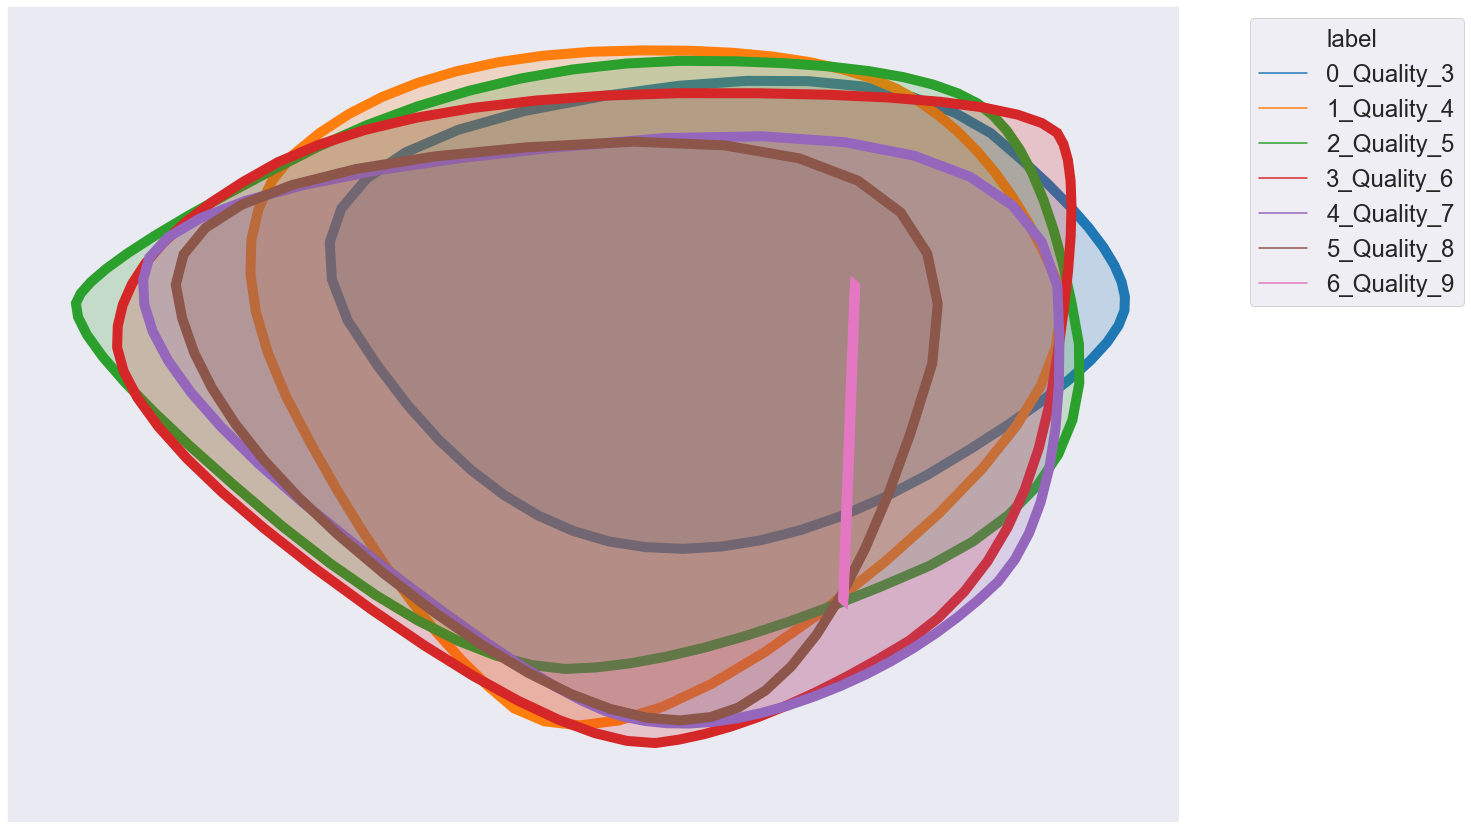

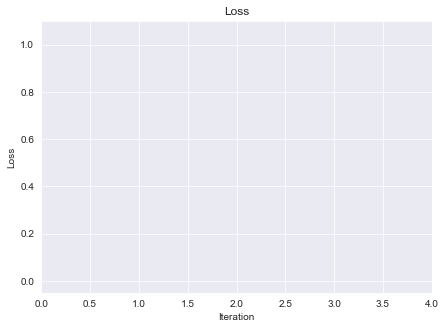

In [16]:
low_sim_blobs = blobs_amap.fit_transform(X, y)

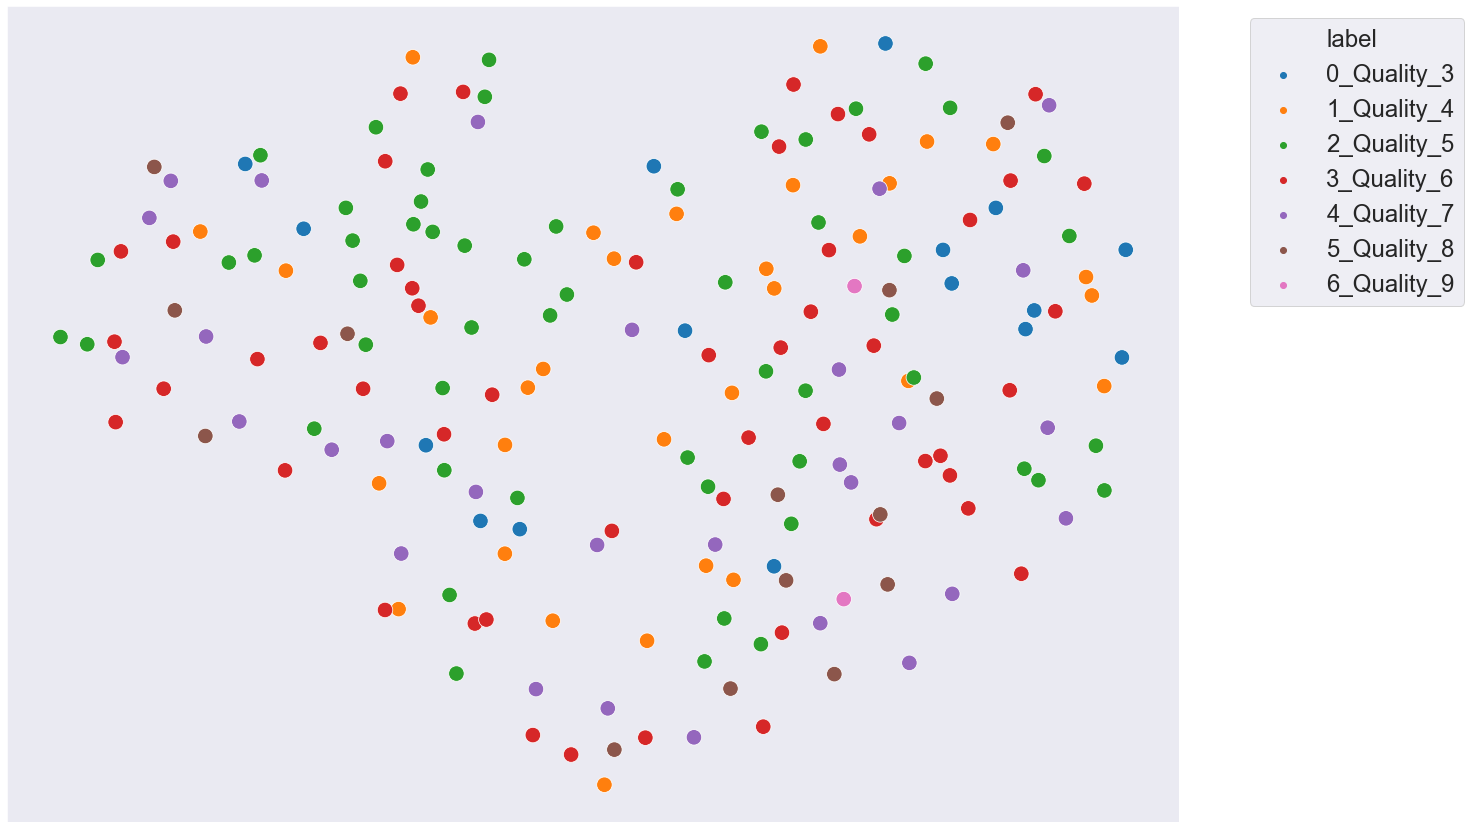

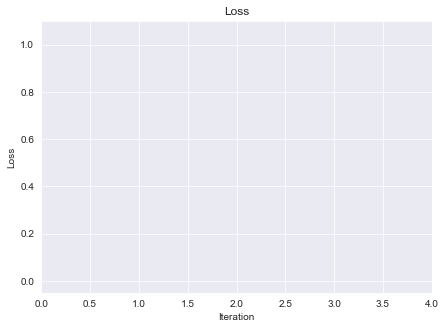

In [21]:
blobs_amap.show_anchors = True
blobs_amap.show_polygons = False
blobs_amap.alpha = [0.3,0,0,0,0,0,0]
blobs_amap.anchors_plot_sns_separate(1, True)